In [1]:
# to handle datasets
import pandas as pd
import numpy as np

# for plotting
import matplotlib.pyplot as plt
%matplotlib inline

#hyperparameter tuning # to divide train and test set
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import label_binarize

#to preprocess the text
from textacy.preprocess import preprocess_text
import nltk
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer

#importing packages for lemming and stemmetizing
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem import WordNetLemmatizer, SnowballStemmer

import warnings
warnings.filterwarnings('ignore')

# to display all the columns of the dataframe in the notebook
pd.pandas.set_option('display.max_columns', None)

The feature engineering part contains engineering of:
    - missing values (imputing with mean/random sample andd creating a binary variable which can capture the missgness)
    - categorical variables (mean and count encoding)
    - discrete variables (rare values engineering)
    - continous variables (extractiong additional variables)
    - text (cleaning, removing the stop words, removing the rare and the most frequent words, spelling correction, Extracting all words with hashtags and '@'. it doesn't include removing the abbreviations)
    
 For the feature selection I checked the chi2 scores. Also while bulding my pipeline I gridserached my model with penelty L1 which was selentec as the best parameter. 
 
 The model part shows the results of gridsearching. I also wanted to check if my model over- or underfit by comparing test and train errors.

In [2]:
# load dataset
data = pd.read_csv('Tweets.csv', usecols = ['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text'] ) #I  will build a model using these features. I would like to preprocess the variables 
                                    # 'tweet_coord', 'tweet_created','tweet_location', 'user_timezone' using the library pytz
                                    # which will help me to extract the additional information from those variables:
                                    # such as location: country or continent. At the moment the variable: Location/timeuser 
                                    # contain only cities which make this variable with high cardinality

# rows and columns of the data
print(data.shape)

# visualise the dataset
data.head(2)

(14640, 11)


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.
1,570301130888122368,positive,0.3486,NaN,0.0,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...


In [3]:
#Removing the duplicates before train and test split
data.drop_duplicates(keep = False)

#check the size
data.shape

(14640, 11)

In [4]:
# Let's separate into train and test set

X_train, X_test, y_train, y_test = train_test_split(data.loc[:, data.columns != 'airline_sentiment'], data.airline_sentiment,
                                                    test_size=0.2,
                                                    random_state=0) # we are setting the seed here
X_train.shape, X_test.shape

((11712, 10), (2928, 10))

In [5]:
# label encoding of a target 
labels = {'positive':1, 'neutral':0, 'negative':-1}
y_train = y_train.map(labels)
y_test = y_test.map(labels)

#the classes disribution of a target on the whole 
y_train.value_counts()/len(y_train)

-1    0.623975
 0    0.212176
 1    0.163849
Name: airline_sentiment, dtype: float64

### Numerical variables

In [6]:
#find all numerical variables
num_vars = [var for var in data.columns if data[var].dtypes != 'O']
num_vars

['tweet_id',
 'airline_sentiment_confidence',
 'negativereason_confidence',
 'retweet_count']

### Discrete variables

In [7]:
#select only the discrete ones
discrete_vars = [var for var in num_vars if len(data[var].unique())<20 and var not in ['tweet_id']+['airline_sentiment']]
[discrete_vars]

[['retweet_count']]

In [8]:
# print variables with missing data
def search_nulls(df, var):
    nulls = df[var].isnull().mean()[df[var].isnull().mean()>0]
    return nulls 

print(search_nulls(X_train, discrete_vars))
print(search_nulls(X_test, discrete_vars))

Series([], dtype: float64)
Series([], dtype: float64)


In [9]:
#see how the discrete variable is distributed on train and test set, ispect if there any categories
#with <1% of tweets in variable
for var in discrete_vars:
    print(var, X_train[var].value_counts()/np.float(len(X_train)))
    print(var, X_test[var].value_counts()/np.float(len(X_test)))

retweet_count 0     0.947490
1     0.044057
2     0.004184
3     0.001537
4     0.001452
5     0.000256
7     0.000171
22    0.000171
6     0.000171
31    0.000085
15    0.000085
44    0.000085
28    0.000085
18    0.000085
8     0.000085
Name: retweet_count, dtype: float64
retweet_count 0     0.948087
1     0.042350
2     0.005806
3     0.001366
5     0.000683
11    0.000342
9     0.000342
7     0.000342
32    0.000342
6     0.000342
Name: retweet_count, dtype: float64


In [10]:
def rare_imputation(variable):    
    # find frequency of labels
    temp = data.groupby([var])[var].count()/np.float(len(data))
    frequent_cat = [x for x in temp.loc[temp>0.01].index.values]
    X_train[var] = np.where(X_train[var].isin(frequent_cat), X_train[var], 'Rare')
    X_test[var] = np.where(X_test[var].isin(frequent_cat), X_test[var], 'Rare')

In [11]:
rare_imputation('retweet_count')

In [12]:
print(X_train.retweet_count.value_counts())
print(X_test.retweet_count.value_counts())

0       11097
1         516
Rare       99
Name: retweet_count, dtype: int64
0       2776
1        124
Rare      28
Name: retweet_count, dtype: int64


In [13]:
#encode rare values with '2' (previously 2 was denoted by 2 tweets)
labels_dict = {k:i for i, k in enumerate(X_train['retweet_count'].unique(), 0)}
X_train['retweet_count'] = X_train['retweet_count'].map(labels_dict )
X_test['retweet_count'] = X_test['retweet_count'].map(labels_dict)

### Continuous variables 

In [14]:
# list of continuous variables
cont_vars = [var for var in num_vars if var not in discrete_vars+['tweet_id']+['airline_sentiment']]
cont_vars

['airline_sentiment_confidence', 'negativereason_confidence']

##### Missing values 

In [15]:
# print variables with missing data
print(search_nulls(X_train, cont_vars))
print(search_nulls(X_test, cont_vars))

negativereason_confidence    0.283811
dtype: float64
negativereason_confidence    0.271175
dtype: float64


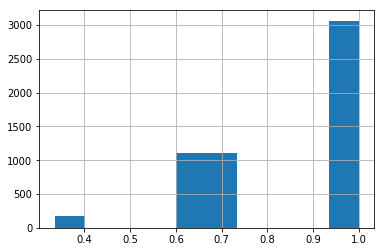

In [16]:
# For most of tweets where the negativereason_confidence wasn't given, the sentiment is positive or neutral.
mask =data[data.negativereason.isnull()==True]
mask.airline_sentiment_confidence.hist()

In [17]:
# see a change in the variance after imputation with median
median = data.negativereason_confidence.median()
print('Original Variance: ', X_train.negativereason_confidence.std())
print('Variance after median imputation: ', X_train.negativereason_confidence.fillna(median).std())

Original Variance:  0.33107759233857276
Variance after median imputation:  0.2805586327534001


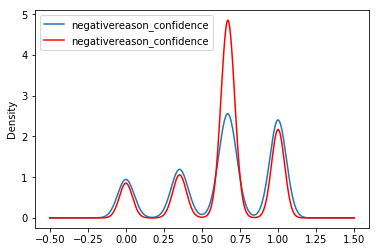

In [18]:
# the distribution has changed slightly with now more values accumulating towards the median
fig = plt.figure()
ax = fig.add_subplot(111)
X_train['negativereason_confidence'].plot(kind='kde', ax=ax)
X_train.negativereason_confidence.fillna(median).plot(kind='kde', ax=ax, color='red')
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')

The median imputation distorts the original distribution of the variable. The transformed variable shows more values around the median value.

##### median imputation and adding an extra binary variable which indicates wheather a value in variable is missing or not

In [19]:
# impute with median and create a binary variable
def impute_na(df, var):
    # calculate the mode
    median = df[var].median()
    
    # replace with median and create an extra binary variable which capture this information
    df[var+'_NA'] = np.where(df[var].isnull(), 1, 0)
    df[var].fillna(median, inplace=True)
    return df[var+'_NA'], df[var]

impute_na(X_train, 'negativereason_confidence')
impute_na(X_test, 'negativereason_confidence')

#make sure that the function workd 
print(X_train.negativereason_confidence.isnull().sum())

#check if the variable was added 
print(X_train.columns)

0
Index(['tweet_id', 'airline_sentiment_confidence', 'negativereason',
       'negativereason_confidence', 'airline', 'airline_sentiment_gold',
       'name', 'negativereason_gold', 'retweet_count', 'text',
       'negativereason_confidence_NA'],
      dtype='object')


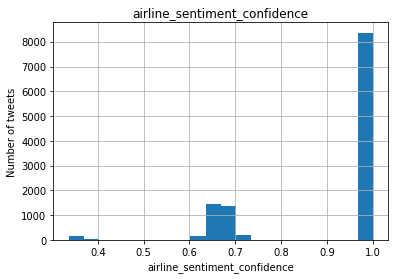

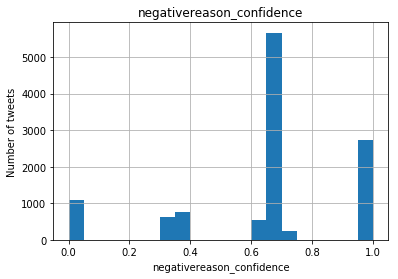

In [20]:
# Let's see how these variables are the distributed
def analyse_continous(df, var):
    df = df.copy()
    df[var].hist(bins=20)
    plt.ylabel('Number of tweets')
    plt.xlabel(var)
    plt.title(var)
    plt.show()
    
for var in cont_vars:
    analyse_continous(X_train, var)

##### binning the continuous variable (equal width binning)

In [21]:
intervals = [0, 0.25, 0.5, 0.75, 1]
X_train['negativereason_confidence_disc'] = pd.cut(x = X_train.negativereason_confidence, labels=[0, 1, 2, 3], bins=intervals, include_lowest=True)
X_test['negativereason_confidence_disc'] = pd.cut(x = X_test.negativereason_confidence, labels=[0, 1, 2, 3], bins=intervals, include_lowest=True)

intervals = [0, 0.25, 0.5, 0.75, 1]
X_train['airline_sentiment_confidence_disc'] = pd.cut(x = X_train.airline_sentiment_confidence, labels=[0, 1, 2, 3], bins=intervals, include_lowest=True)
X_test['airline_sentiment_confidence_disc'] = pd.cut(x = X_test.airline_sentiment_confidence, labels=[0, 1, 2, 3], bins=intervals, include_lowest=True)

In [22]:
for var in ['negativereason_confidence_disc', 'airline_sentiment_confidence_disc' ]:
    labels_dict = {k:i for i, k in enumerate(X_train[var].unique(), 0)}
    X_train.loc[:, var] = X_train.loc[:, var].map(labels_dict )
    X_test.loc[:, var] = X_test.loc[:, var].map(labels_dict)

In [23]:
X_test.negativereason_confidence_disc.unique()
X_test.airline_sentiment_confidence_disc.unique()

array([0, 1, 2], dtype=int64)

##### the relationship between the target and variables which were binned

In [24]:
# if the distributions in train and test set are similar, we should expect similar distribution of 
# observations in the different intervals in the train and test set

temp_train = pd.concat([X_train, y_train], axis = 1)
temp_test = pd.concat([X_test, y_test], axis = 1)
t1 = temp_train.groupby(['negativereason_confidence_disc'])['airline_sentiment'].count() / np.float(len(X_train))
t2 = temp_test.groupby(['negativereason_confidence_disc'])['airline_sentiment'].count() / np.float(len(X_test))

Text(0.5, 0, 'airline_sentiment_confidence_disc')

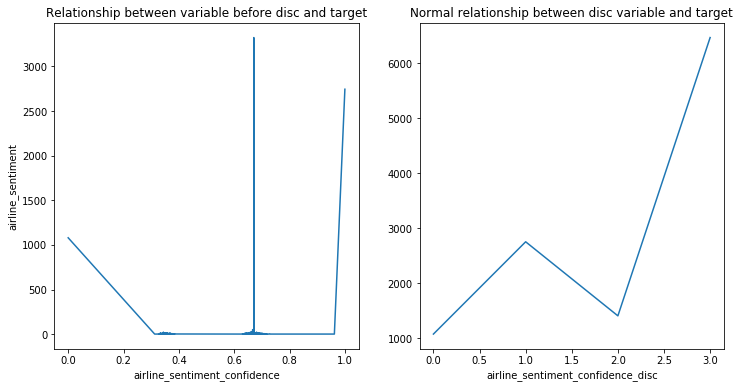

In [25]:
# and now let's observe the relationship between age and surival again, using the discrete Age transformed 
# variable

plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
fig = temp_train.groupby(['negativereason_confidence'])['airline_sentiment'].count().plot(figsize=(12,6))
fig.set_title('Relationship between variable before disc and target')
fig.set_ylabel('airline_sentiment')
fig.set_xlabel('airline_sentiment_confidence')

plt.subplot(1, 2, 2)
fig = temp_train.groupby(['negativereason_confidence_disc'])['airline_sentiment'].count().plot(figsize=(12,6))
fig.set_title('Normal relationship between disc variable and target')
fig.set_xlabel('airline_sentiment_confidence_disc')

Text(0.5, 0, 'airline_sentiment_confidence_disc')

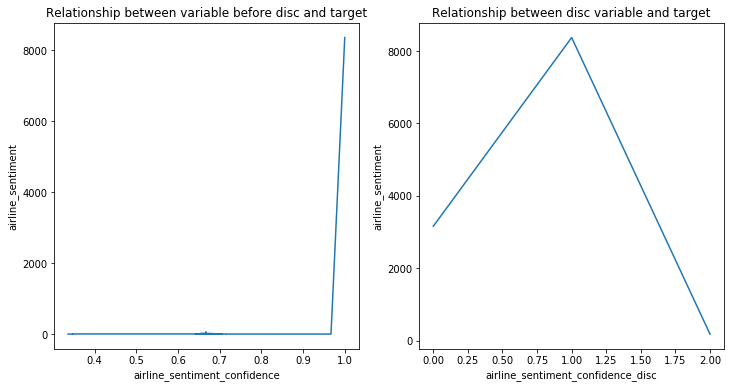

In [26]:
# and now let's observe the relationship between age and surival again, using the discrete transformed 
# variable

plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
fig = temp_train.groupby(['airline_sentiment_confidence'])['airline_sentiment'].count().plot(figsize=(12,6))
fig.set_title('Relationship between variable before disc and target')
fig.set_ylabel('airline_sentiment')
fig.set_xlabel('airline_sentiment_confidence')

# and now let's observe the relationship between age and surival again, using the discrete transformed 
# variable

plt.subplot(1, 2, 2)
fig = temp_train.groupby(['airline_sentiment_confidence_disc'])['airline_sentiment'].count().plot(figsize=(12,6))
fig.set_title('Relationship between disc variable and target')
fig.set_ylabel('airline_sentiment')
fig.set_xlabel('airline_sentiment_confidence_disc')

The relationship between the airline_sentiment_confidence and target looks quite monotonic. On the ther hand, binning 'negativereason_confidence' variable which was imputed with median distorted the relationship between the target and predictor

### Categorical variables

In [27]:
### find all categorical variables in dataset
cat_vars = [var for var in data.columns if data[var].dtypes=='O' and var not in ['text']+['airline_sentiment']]
cat_vars

['negativereason',
 'airline',
 'airline_sentiment_gold',
 'name',
 'negativereason_gold']

##### Missing values 

In [28]:
# print variables with missing data
print(search_nulls(X_train, cat_vars))
print(search_nulls(X_test, cat_vars))

negativereason            0.376025
airline_sentiment_gold    0.997012
negativereason_gold       0.997695
dtype: float64
negativereason            0.361339
airline_sentiment_gold    0.998292
negativereason_gold       0.998292
dtype: float64


I will drop the variables with the missing values >99%. I will impute the missing values with a random sample in the variable negativereason and create a binary viarable which can capture wheather the value is missing or not.

In [29]:
#dropping columns with the missing values >99%
for var in ['airline_sentiment_gold', 'negativereason_gold']:
    X_train.drop([var], axis = 1, inplace = True)
    X_test.drop([var], axis = 1, inplace = True)

#see the columns 
X_train.columns

Index(['tweet_id', 'airline_sentiment_confidence', 'negativereason',
       'negativereason_confidence', 'airline', 'name', 'retweet_count', 'text',
       'negativereason_confidence_NA', 'negativereason_confidence_disc',
       'airline_sentiment_confidence_disc'],
      dtype='object')

In [30]:
# replace the missing values with a random sample and create an extra variable which can capture 
# the missingness 

def impute_na(df, var):
    # add additional variable to indicate missingness
    df[var+'_NA'] = np.where(df[var].isnull(), 1, 0)
    
    #random sampling
    df[var+'_random'] = df[var]#adding a new variable so I can compare with the one which was not imputed 
    
    # extract the random sample to fill the na
    random_sample = df[var].dropna().sample(df[var].isnull().sum())
    
    # pandas needs to have the same index in order to merge datasets
    random_sample.index = df[df[var].isnull()].index
    
    df.loc[df[var].isnull(), var+'_random'] = random_sample
    
    return df[var+'_NA'], df[var+'_random']    

In [31]:
impute_na(X_train, 'negativereason')
impute_na(X_test, 'negativereason')

#see if the function worked
X_train.negativereason_random.isnull().sum()

0

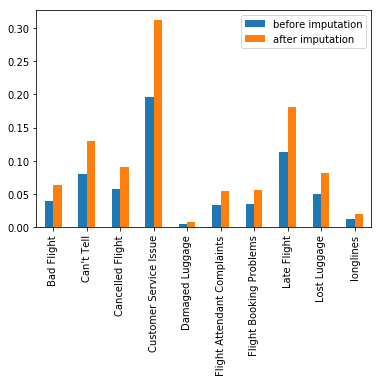

In [32]:
#compare variable before and after imputation
var1 = X_train.groupby(['negativereason'])['negativereason'].count() / np.float(len(X_train))
var2 = X_train.groupby(['negativereason_random'])['negativereason_random'].count() / np.float(len(X_train))
temp = pd.concat([var1,var2], axis=1)
temp.columns = ['before imputation', 'after imputation']
temp.plot.bar()

In [33]:
#random sampling assigned more values to of negative reason do positive and neutral sentiment which
#weren't present in the training set before 
temp = pd.concat([X_train[['negativereason', 'negativereason_random']], y_train], axis=1)
temp.groupby('airline_sentiment')['negativereason_random', 'negativereason'].count()

,negativereason_random,negativereason
airline_sentiment,,
-1,7308,7308
0,2485,0
1,1919,0


If we look at the variable which was imputed by the random sampling, we can notice that some of the data points were assigned to the positive and neutral airline sentiment. The variable before imputation with random sample included only the data points which reflected negative sentiment

##### cardinality 

In [34]:
#get all categorical variables
cat_vars = [var for var in X_train.columns if X_train[var].dtypes=='O' and var not in ['text']]
cat_vars.sort()

In [35]:
#distribution of the variables 
for var in cat_vars:
    if len(X_train[var].unique()):
        print(var, X_train.groupby(var)[var].count()/np.float(len(X_train)))
        print('---'*20)

airline airline
American          0.188866
Delta             0.150359
Southwest         0.164959
US Airways        0.197490
United            0.264771
Virgin America    0.033555
Name: airline, dtype: float64
------------------------------------------------------------
name name
0504Traveller      0.000427
09202010           0.000171
0veranalyser       0.000085
0xjared            0.000085
1234567890_        0.000085
140JustinC         0.000427
18handicap         0.000085
1JENSABA           0.000256
1KingMeech         0.000085
1LovePT            0.000171
1MisterHandsome    0.000342
1_7_8_0            0.000085
1malindac          0.000085
1stcrown           0.000085
201Chef            0.000171
215strongbul       0.000085
219jondn           0.000171
21stCenturyMom     0.000256
2533107724Paul     0.000171
27_POWERS          0.000171
29MC29             0.000085
2Hats1Mike         0.000085
2cJustice4all      0.000427
2littlebirds       0.000171
2lnr               0.000085
2tsieRole          0.

##### count encoding

The variable 'name' has a high cardinality. It contains multiple labels, then by re-encoding them using one hot encoding, I would expand the feature space dramatically. I will replace each label of the categorical variable by the count, this is the amount of times each label appears in the dataset

In [36]:
#count encoding the variable 'name'

#make the dictionary mapping label to counts on the whole dataset
X_frequency_map = data['name'].value_counts().to_dict()
        
# remap the labels to their counts on the training and test sets
X_train['name'] = X_train['name'].map(X_frequency_map)
X_test['name'] = X_test['name'].map(X_frequency_map)

In [37]:
X_train['name'].unique()

array([ 3,  4,  2,  1, 11, 10,  5,  9,  8, 63,  7,  6, 15, 14, 12, 19, 29,
       23, 32, 13, 22, 16, 21, 27, 18, 28, 17, 20], dtype=int64)

In [38]:
X_test['name'].unique()

array([ 2,  4, 23,  1, 20,  3,  6, 63,  5, 21, 12, 13,  8,  7, 10, 14,  9,
       28, 19, 11, 17, 22, 29, 27, 18, 32, 16, 15], dtype=int64)

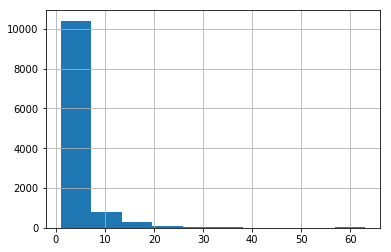

In [39]:
#the variable 'name' has one predominant category with the users who tweeted
#less 5 times
X_train['name'].hist(bins=10)

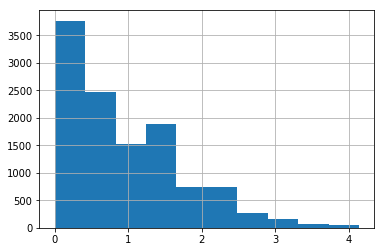

In [40]:
#log transformation doesn't help too much. The variable has one predominant category.
np.log(X_train['name']).hist()
#X_test['name']= np.log(X_test['name'])

##### encoding categorical variables

Mean ecoding this is equivalent to the probability of sentiment of tweets.

In [41]:
### find all categorical variables in dataset
cat_vars = [var for var in X_train.columns if X_train[var].dtypes=='O' and var not in ['text']]
cat_vars

['negativereason', 'airline', 'negativereason_random']

In [42]:
# look at how many labels
for var in cat_vars:
    print(var, ': ', len(X_train[var].unique()), ' labels')

negativereason :  11  labels
airline :  6  labels
negativereason_random :  10  labels


Text(0, 0.5, 'airline_sentiment')

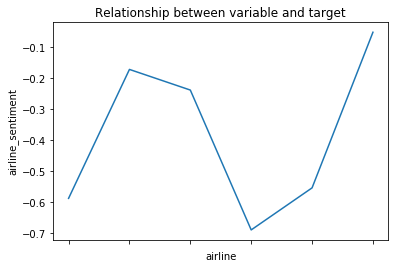

In [43]:
# plot the transformed result: the monotonic variable

fig = plt.figure()
temp_train = pd.concat([X_train, y_train], axis = 1)
fig = temp_train.groupby(['airline'])['airline_sentiment'].mean().plot()
fig.set_title('Relationship between variable and target')
fig.set_ylabel('airline_sentiment')

In [44]:
for var in ['airline' ]:
    labels_dict = {k:i for i, k in enumerate(X_train[var].unique(), 0)}
    X_train.loc[:, var] = X_train.loc[:, var].map(labels_dict )
    X_test.loc[:, var] = X_test.loc[:, var].map(labels_dict)

In [45]:
X_train.airline.unique()

array([0, 1, 2, 3, 4, 5], dtype=int64)

In [46]:
# and now let's do the same but capturing the result in a dictionary
temp_train = pd.concat([X_train, y_train], axis = 1)
ordered_labels = temp_train.groupby(['airline'])['airline_sentiment'].mean().to_dict()
ordered_labels

{0: -0.17092561044860874,
 1: -0.5533698806836505,
 2: -0.5872513562386981,
 3: -0.2375776397515528,
 4: -0.6891482922611327,
 5: -0.05089058524173028}

In [47]:
X_train['airline'] = X_train.airline.map(ordered_labels)
X_test['airline'] = X_test.airline.map(ordered_labels)

Text(0, 0.5, 'airline_sentiment')

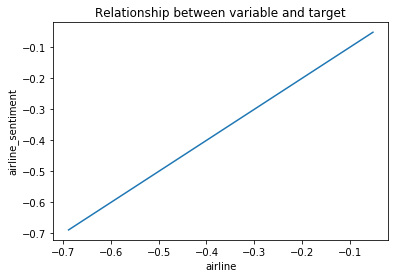

In [48]:
# plot the transformed result: the monotonic variable
fig = plt.figure()
temp_train = pd.concat([X_train, y_train], axis = 1)
fig = temp_train.groupby(['airline'])['airline_sentiment'].mean().plot()
fig.set_title('Relationship between variable and target')
fig.set_ylabel('airline_sentiment')

Text(0, 0.5, 'airline_sentiment')

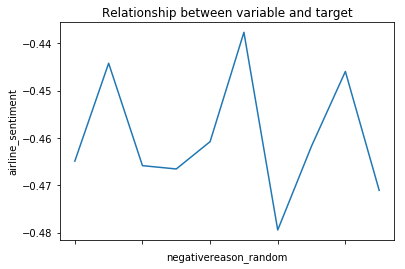

In [49]:
# plot the transformed result: the monotonic variable
fig = plt.figure()
temp_train = pd.concat([X_train, y_train], axis = 1)
fig = temp_train.groupby(['negativereason_random'])['airline_sentiment'].mean().plot()
fig.set_title('Relationship between variable and target')
fig.set_ylabel('airline_sentiment')

In [50]:
for var in ['negativereason_random' ]:
    labels_dict = {k:i for i, k in enumerate(X_train[var].unique(), 0)}
    X_train.loc[:, var] = X_train.loc[:, var].map(labels_dict )
    X_test.loc[:, var] = X_test.loc[:, var].map(labels_dict)

In [51]:
X_train.negativereason_random.unique()

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

In [52]:
# and now let's do the same but capturing the result in a dictionary
temp_train = pd.concat([X_train, y_train], axis = 1)
ordered_labels = temp_train.groupby(['negativereason_random'])['airline_sentiment'].mean().to_dict()
X_train['negativereason_random'] = X_train['negativereason_random'].map(ordered_labels)
X_test['negativereason_random'] = X_test['negativereason_random'].map(ordered_labels)

Text(0, 0.5, 'airline_sentiment')

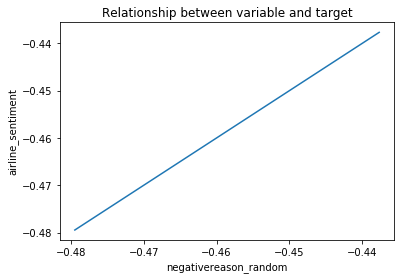

In [53]:
# plot the transformed result: the monotonic variable
fig = plt.figure()
temp_train = pd.concat([X_train, y_train], axis = 1)
fig = temp_train.groupby(['negativereason_random'])['airline_sentiment'].mean().plot()
fig.set_title('Relationship between variable and target')
fig.set_ylabel('airline_sentiment')

Text(0, 0.5, 'airline_sentiment')

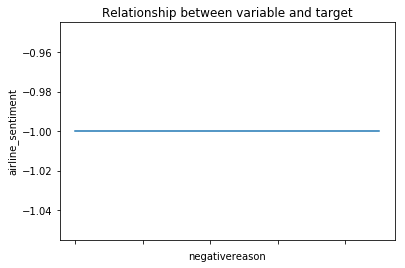

In [54]:
# plot the transformed result: the monotonic variable
fig = plt.figure()
temp_train = pd.concat([X_train, y_train], axis = 1)
fig = temp_train.groupby(['negativereason'])['airline_sentiment'].mean().plot()
fig.set_title('Relationship between variable and target')
fig.set_ylabel('airline_sentiment')

In [55]:
#random sampling assigned more values to of negative reason do positive and neutral sentiment which
#weren't present in the training set before 
temp = pd.concat([X_train, y_train], axis=1)
temp.groupby('airline_sentiment')['negativereason_random', 'negativereason'].count()

,negativereason_random,negativereason
airline_sentiment,,
-1,7308,7308
0,2485,0
1,1919,0


In [56]:
X_train.drop(['negativereason'], axis = 1, inplace = True)
X_test.drop(['negativereason'], axis = 1, inplace = True)

#see the columns 
X_train.columns

Index(['tweet_id', 'airline_sentiment_confidence', 'negativereason_confidence',
       'airline', 'name', 'retweet_count', 'text',
       'negativereason_confidence_NA', 'negativereason_confidence_disc',
       'airline_sentiment_confidence_disc', 'negativereason_NA',
       'negativereason_random'],
      dtype='object')

### Feature selection

In [57]:
cat_vars = [
 'airline_sentiment_confidence', #imputed with median
 'negativereason_confidence',#imputed with median 
 'name',#count encoding 
 'retweet_count',#rare values engineering
 'negativereason_confidence_NA',#binary variable which indicate the missingness 
 'negativereason_confidence_disc',#encoded equal width binned variable
 'airline_sentiment_confidence_disc',#encoded equal width binned variable
 ]

In [58]:
from sklearn.feature_selection import chi2
f_score = chi2(X_train[cat_vars], y_train)
f_score 

(array([  28.45762691,  244.24498083,  906.71778798,   63.17814447,
        5652.06241195,  220.89326637,  167.83934592]),
 array([6.61461899e-007, 9.18071059e-054, 1.28449973e-197, 1.91003023e-014,
        0.00000000e+000, 1.08052959e-048, 3.58219407e-037]))

In [59]:
pvalues = pd.Series(f_score[1])
pvalues.index = X_train[cat_vars].columns 
pvalues.sort_values(ascending = False)

airline_sentiment_confidence          6.614619e-07
retweet_count                         1.910030e-14
airline_sentiment_confidence_disc     3.582194e-37
negativereason_confidence_disc        1.080530e-48
negativereason_confidence             9.180711e-54
name                                 1.284500e-197
negativereason_confidence_NA          0.000000e+00
dtype: float64

All categorical variables have the ultra tiny p_values and they look as they would be highly predictive. Maybe this indicates that the dataset contains too many sapmple. While bulding the pipeline I will try to penelize logistic regression this will help me to shrinkage the coefficients which are smalll or equal to zero.

### Text

The texts from twitter usually require lots of preprocessing steps. Below some examples:

In [60]:
#example of tweets which need to be preprocessed 
print(X_train.loc[5874, 'text'])#removing emoji, punctuation, @mentions words
print(X_train.loc[7877, 'text'])#removing hashtags and @mentions words
print(X_train.loc[12556, 'text'])#spelling correction
print(X_train.loc[6516, 'text'])#removing repeating characters

@SouthwestAir thank you! ❤️❤️❤️ you guys!
@JetBlue Even though this flight #226 didn't have much needed hot beverages 4 us NY-ers, the landing was super smooth 👍👍 😊 #happytweet
@AmericanAir 2284, four hours Late Flightrs and we are finally flying out...too bad I missed my event
@SouthwestAir Awwweesssooomee!


There are also abbreviation forms which should be preprocessed as well as the words with repeating characters such as 'Awwweesssooomee'. I will focus only on extracting the hashtags and @mentions words, removing the most frequent and rare words, removing stop words, spelling corection, removing the emoji and punctuation, lemmatization of text.

##### Basic preprocessing

In [61]:
#The first pre-processing step which we will do is transform our tweets into lower case. 
#This avoids having multiple copies of the same words
X_train['text'] = X_train['text'].apply(lambda x: " ".join(x.lower() for x in x.split()))
X_test['text'] = X_test['text'].apply(lambda x: " ".join(x.lower() for x in x.split()))
print(X_train.loc[5874, 'text'])
print(X_train.loc[7877, 'text'])
print(X_train.loc[12556, 'text'])

@southwestair thank you! ❤️❤️❤️ you guys!
@jetblue even though this flight #226 didn't have much needed hot beverages 4 us ny-ers, the landing was super smooth 👍👍 😊 #happytweet
@americanair 2284, four hours late flightrs and we are finally flying out...too bad i missed my event


###### removal of all words with hashtags from the tweets

In [62]:
#getting all words with hashtags in the text. By doing that I want to remove a noise from my model
hashtags=[]
for row in data.text:
    for i in row.split():
        if i.startswith("#"):
            hashtags.append(i)
len(set(hashtags))        

hashtags[:10]

['#fabulous',
 '#Seductive',
 '#stress',
 '#29DaysToGo',
 '#fail',
 '#VX358',
 '#noair',
 '#worstflightever',
 '#roasted',
 '#SFOtoBOS']

In [63]:
#I will remove the words with hashtags from text. I am aware that I could add an extra column with extracted features and
#see if they are redundant (a columns with airline)
X_train['text'] = X_train['text'].apply(lambda x: " ".join(x for x in x.split() if x not in hashtags))
X_test['text'] = X_test['text'].apply(lambda x: " ".join(x for x in x.split() if x not in hashtags))

In [64]:
print(X_train.loc[5874, 'text'])
print(X_train.loc[7877, 'text'])
print(X_train.loc[12556, 'text'])

@southwestair thank you! ❤️❤️❤️ you guys!
@jetblue even though this flight didn't have much needed hot beverages 4 us ny-ers, the landing was super smooth 👍👍 😊
@americanair 2284, four hours late flightrs and we are finally flying out...too bad i missed my event


###### removing all @Mentions words

In [65]:
#getting all words starting with @
names=[]
for row in data.text:
    for i in row.split():
        if i.startswith("@"):
            names.append(i)
            
print(len(set(names)))

1006


In [66]:
names[:4]

['@VirginAmerica', '@dhepburn', '@VirginAmerica', '@VirginAmerica']

In [67]:
X_train['text'] = X_train['text'].apply(lambda x: " ".join(x for x in x.split() if x not in names))
X_test['text'] = X_test['text'].apply(lambda x: " ".join(x for x in x.split() if x not in names))
print(X_train.loc[5874, 'text'])
print(X_train.loc[7877, 'text'])
print(X_train.loc[12556, 'text'])

thank you! ❤️❤️❤️ you guys!
even though this flight didn't have much needed hot beverages 4 us ny-ers, the landing was super smooth 👍👍 😊
2284, four hours late flightrs and we are finally flying out...too bad i missed my event


###### removing punctuation and emoji

In [68]:
#removing punctuation and emoji
#The next step is to remove punctuation, as it doesn’t add any extra information while treating text data. 
#Therefore removing all instances of it will help us reduce the size of the training data.

X_train['text'] = X_train['text'].str.replace('[^\w\s]',' ')
X_test['text'] = X_test['text'].str.replace('[^\w\s]',' ')
print(X_train.loc[5874, 'text'])
print(X_train.loc[7877, 'text'])
print(X_train.loc[12556, 'text'])

thank you         you guys 
even though this flight didn t have much needed hot beverages 4 us ny ers  the landing was super smooth     
2284  four hours late flightrs and we are finally flying out   too bad i missed my event


###### removing the names of the users from tweets

In [69]:
names = data.name.unique().tolist()

In [70]:
X_train['text'] = X_train['text'].apply(lambda x: " ".join(x for x in x.split() if x not in names))
X_test['text'] = X_test['text'].apply(lambda x: " ".join(x for x in x.split() if x not in names))

###### removing stop words

In [71]:
#removing stop words (or commonly occurring words) again after rowing punctuation

from nltk.corpus import stopwords
stop = stopwords.words('english')
stop.extend(['http', 'could', 'would', 'ref'])
X_train['text'] = X_train['text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
X_test['text'] = X_test['text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
print(X_train.loc[5874, 'text'])
print(X_train.loc[7877, 'text'])
print(X_train.loc[12556, 'text'])

thank guys
even though flight much needed hot beverages 4 us ny ers landing super smooth
2284 four hours late flightrs finally flying bad missed event


In [72]:
#getting the first 10 elements of the stopwords
print(stop[10:])

["you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "shou

###### Spelling correction

In [114]:
#We’ve all seen tweets with a plethora of spelling mistakes. They are often filled 
#with hastly sent tweets that are barely legible at times. In that regard, spelling correction is 
#a useful pre-processing step because this also will help us in reducing multiple copies of words. 

#One of the helpfull libraries which helps in spelling correction is textblob. 

from textblob import TextBlob
text = TextBlob('dfwairport')
print(text.correct())

text = TextBlob('flightled')
print(text.correct())

text = TextBlob('ur')
print(text.correct())

text = TextBlob('2284 four hour late flightrs finally flying bad missed event')
print(text.correct())

dfwairport
lighted
or
2284 four hour late flights finally flying bad missed event


In some cases the Textblob corrects the words in the right way fligtrs -> flights. It also didn't changed the meaning of the word 'dfwairport', which is also good
But 'flightled' was changed to 'lighted' and this is not correct.

Except for spelling error my text also contains lots of abbreviations. For example 'ur' stands for 'your' which corrected by TextBlob and changed to 'our'. I decided to correct manually the most occuring words and don't use the Text Blob for now.

In [74]:
for word in ['flightr', 'flightrs', 'reflight', 'flighted', 'flightlations', 'flightlation', 'flighting', 'flightled', 'flights']:
    X_train['text'] = X_train['text'].str.replace(word, 'flight')
    X_test['text'] = X_test['text'].str.replace(word, 'flight')

In [75]:
print(X_train.loc[5874, 'text'])
print(X_train.loc[7877, 'text'])
print(X_train.loc[12556, 'text'])

thank guys
even though flight much needed hot beverages 4 us ny ers landing super smooth
2284 four hours late flight finally flying bad missed event


###### removing the common words

In [76]:
#let’s check the 10 most frequently occurring words in our text data then take call 
#to remove or retain.
freq = pd.Series(' '.join(X_train['text']).split()).value_counts()[:1]
freq

flight    4474
dtype: int64

In [77]:
#
#freq = list(freq.index)
X_train['text'] = X_train['text'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
X_test['text'] = X_test['text'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
print(X_train.loc[5874, 'text'])
print(X_train.loc[7877, 'text'])
print(X_train.loc[12556, 'text'])

thank guys
even though much needed hot beverages 4 us ny ers landing super smooth
2284 four hours late finally flying bad missed event


###### Rare words removal

In [78]:
#Similarly, just as we removed the most common words, this time let’s remove rarely occurring 
#words from the text. Because they’re so rare, the association between them and 
#other words is dominated by noise
# I will remove the rare words after lemmatizing the text

freq = pd.Series(' '.join(X_train['text']).split()).value_counts()[-100:]
freq[:10]

petty            1
realistically    1
srm13qbrzd       1
otfz7cyguq       1
mojave           1
lining           1
relay            1
2spooky          1
gth239           1
oylgeao7y8       1
dtype: int64

##### Lemmatization

In [79]:
# Lemmatization is a more effective option than stemming because it converts the word into its root word, 
# rather than just stripping the suffices. It makes use of the vocabulary and does a morphological analysis 
# to obtain the root word.

#For example, runs, running, ran are all forms of the word run, therefore run is 
#the lemma of all these words. Because lemmatization returns an actual word of the language, 
#it is used where it is necessary to get valid words.

In [80]:
def stem_lem_text(s, type='Lancaster'):
    words = s.split()
    
    if type == 'Porter':
        choice = PorterStemmer()
        reformed = [choice.stem(word) for word in words]
    elif type == 'Snowball':
        choice = SnowballStemmer('english')
        reformed = [choice.stem(word) for word in words]
    elif type == 'Lemmatize':
        choice = WordNetLemmatizer()
        reformed = [choice.lemmatize(word) for word in words]
    else:
        choice = LancasterStemmer()
        reformed = [choice.stem(word) for word in words]
        
    reformed = " ".join(reformed)
    return reformed

In [81]:
X_train.text = X_train.text.apply(stem_lem_text, type='Lemmatize')
X_test.text = X_test.text.apply(stem_lem_text, type='Lemmatize')

In [82]:
print(X_train.loc[5874, 'text'])
print(X_train.loc[7877, 'text'])
print(X_train.loc[12556, 'text'])

thank guy
even though much needed hot beverage 4 u ny er landing super smooth
2284 four hour late finally flying bad missed event


###### Rare words removal

In [83]:
#Similarly, just as we removed the most common words, this time let’s remove rarely occurring 
#words from the text. Because they’re so rare, the association between them and 
#other words is dominated by noise
freq = pd.Series(' '.join(X_train['text']).split()).value_counts()[-300:]
freq[:10]

7c               1
tonne            1
8uxzj2           1
multinational    1
ourguest         1
combat           1
cehroeurc5       1
illiterate       1
15yr             1
kindly           1
dtype: int64

In [84]:
X_train['text'] = X_train['text'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
X_test['text'] = X_test['text'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
print(X_train.loc[5874, 'text'])
print(X_train.loc[7877, 'text'])
print(X_train.loc[12556, 'text'])

thank guy
even though much needed hot beverage 4 u ny er landing super smooth
2284 four hour late finally flying bad missed event


In [85]:
#N-grams
#The basic principle behind n-grams is that they capture the language structure, 
#like what letter or word is likely to follow the given one. The longer the n-gram 
#(the higher the n), the more context you have to work with. Optimum length really 
#depends on the application – if your n-grams are too short, you may fail to capture 
#important differences. 
TextBlob(X_train['text'][10]).ngrams(2)

[WordList(['know', 'suicide']),
 WordList(['suicide', 'second']),
 WordList(['second', 'leading']),
 WordList(['leading', 'cause']),
 WordList(['cause', 'death']),
 WordList(['death', 'among']),
 WordList(['among', 'teen']),
 WordList(['teen', '10']),
 WordList(['10', '24'])]

##### Term frequency

In [86]:
# Term frequency is simply the ratio of the count of a word present in a sentence, 
# to the length of the sentence.
#Therefore, we can generalize term frequency as:
#TF = (Number of times term T appears in the particular row) / (number of terms in that row
tf1 = (X_train['text'][1:2]).apply(lambda x: pd.value_counts(x.split(" "))).sum(axis = 0).reset_index()
tf1.columns = ['words','tf']
tf1

,words,tf
0,yes,1
1,unsure,1
2,amp,1
3,come,1
4,airline,1
5,never,1
6,time,1
7,happened,1
8,first,1


##### Inverse Document Frequency

The intuition behind inverse document frequency (IDF) is that a word is not of much use to us if it’s appearing in all the documents. Therefore, the IDF of each word is the log of the ratio of the total number of rows to the number of rows in which that word is present.

IDF = log(N/n), where, N is the total number of rows and n is the number of rows in which the word was present.

So, let’s calculate IDF for the same tweets for which we calculated the term frequency.

In [87]:
for i,word in enumerate(tf1['words']):
    tf1.loc[i, 'idf'] = np.log(X_train.shape[0]/(len(X_train[X_train['text'].str.contains(word)])))

tf1

,words,tf,idf
0,yes,1,3.698488
1,unsure,1,8.675222
2,amp,1,3.073103
3,come,1,4.478020
4,airline,1,3.250272
5,never,1,3.803849
6,time,1,2.737686
7,happened,1,5.518222
8,first,1,4.002393


The more the value of IDF, the more unique is the word.

##### Term Frequency – Inverse Document Frequency (TF-IDF)
TF-IDF is the multiplication of the TF and IDF which we calculated above.

In [88]:
tf1['tfidf'] = tf1['tf'] * tf1['idf']
tf1

,words,tf,idf,tfidf
0,yes,1,3.698488,3.698488
1,unsure,1,8.675222,8.675222
2,amp,1,3.073103,3.073103
3,come,1,4.478020,4.478020
4,airline,1,3.250272,3.250272
5,never,1,3.803849,3.803849
6,time,1,2.737686,2.737686
7,happened,1,5.518222,5.518222
8,first,1,4.002393,4.002393


We can see that the TF-IDF has penalized words which are commonly occurring words. However, it has given a high weight to “thanks” and "hour" and "cancelled" since that will be very useful in determining the sentiment of the tweet.

In [89]:
from sklearn.feature_extraction.text import TfidfVectorizer
tdidf = TfidfVectorizer(max_features=30, stop_words='english',
                     ngram_range=(1, 2), binary=True)
pd.DataFrame(tdidf.fit_transform(X_train['text']).sum(
    axis=0).reshape(-1, 1), index=tdidf.get_feature_names(), columns=['count']).sort_values('count', ascending=False)

,count
thanks,671.317094
hour,557.485807
cancelled,550.284146
time,498.771810
help,478.389505
service,445.524895
bag,435.905526
customer,418.350231
thank,412.980427
plane,402.180633


##### Bags of words 

Bag of Words (BoW) refers to the representation of text which describes the presence of words within the text data. The intuition behind this is that two similar text fields will contain similar kind of words, and will therefore have a similar bag of words. Further, that from the text alone we can learn something about the meaning of the document.

In [90]:
# use count vectorizer to assess the most used words in companies
cv = CountVectorizer(max_features=30, stop_words='english',
                     ngram_range=(1, 2), binary=True)
pd.DataFrame(cv.fit_transform(X_train['text']).sum(
    axis=0).reshape(-1, 1), index=cv.get_feature_names(), columns=['count']).sort_values('count', ascending=False)

,count
hour,896
thanks,868
cancelled,807
service,770
customer,727
time,712
help,693
bag,573
plane,547
amp,501


#### saving to csv file

In [91]:
train_set = pd.concat([X_train, y_train], axis=1)
test_set = pd.concat([X_test, y_test], axis=1)

In [92]:
#check the missing values before saving
train_set.isnull().sum()

tweet_id                             0
airline_sentiment_confidence         0
negativereason_confidence            0
airline                              0
name                                 0
retweet_count                        0
text                                 0
negativereason_confidence_NA         0
negativereason_confidence_disc       0
airline_sentiment_confidence_disc    0
negativereason_NA                    0
negativereason_random                0
airline_sentiment                    0
dtype: int64

In [93]:
test_set.isnull().sum()

tweet_id                             0
airline_sentiment_confidence         0
negativereason_confidence            0
airline                              0
name                                 0
retweet_count                        0
text                                 0
negativereason_confidence_NA         0
negativereason_confidence_disc       0
airline_sentiment_confidence_disc    0
negativereason_NA                    0
negativereason_random                0
airline_sentiment                    0
dtype: int64

#### Model

In [94]:
# to build the models
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, auc

#
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer

#to set the pipelines 
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion

In [95]:
# let's now save the train and test sets for the next notebook!

train_set.to_csv('xtrain.csv', index=False)
test_set.to_csv('xtest.csv', index=False)

In [96]:
# drop unnecessary variables from our training and testing sets
X_train.drop(['tweet_id'], axis=1, inplace=True)
X_test.drop(['tweet_id'], axis=1, inplace=True)

In [97]:
# Import FunctionTransformer
from sklearn.preprocessing import FunctionTransformer

#get all numerical variables
num_vars = [var for var in X_train.columns if X_train[var].dtypes != 'O']

# Obtain the text data: get_text_data
get_text_data = FunctionTransformer(lambda x: x['text'], validate=False)

# Obtain the numeric data: get_numeric_data
get_numeric_data = FunctionTransformer(lambda x: x[num_vars], validate=False)

In [98]:
# Create a FeatureUnion with nested pipeline: process_and_join_features
process_and_join_features = FeatureUnion(
            transformer_list = [
                ('numerical', Pipeline([
                    ('selector_n', get_numeric_data),
                ])),
                ('bagwords', Pipeline([
                    ('selector', get_text_data),
                    ('cvec', CountVectorizer()),
                    ('tfidf',TfidfTransformer())
                ]))
             ]
        )

# Instantiate nested pipeline: pl
pipelinemodel = Pipeline([
        ('feats', process_and_join_features),
    ('ss',StandardScaler(with_mean=False)),
    
        ('logreg', LogisticRegression())
    ])

#numeric_features__text_features__vectorizer__
# Fit pl to the training data
pipelinemodel.fit(X_train, y_train)

# Compute and print accuracy on the train and test set
print("\nAccuracy train set: ", pipelinemodel.score(X_test, y_test))


Accuracy train set:  0.9047131147540983


If we are computing the accurancy on your test set the score returned is dependent on the way that you split up the data. The data points in the test set may have some peculiarities that mean the accurancy computed on it is not representative of the model’s ability to generalize to unseen data. To combat this dependence on what is essentially an arbitrary split, we use a cross-validation.

In [99]:
kfold = KFold(n_splits=4, random_state=27)
scores = cross_val_score(pipelinemodel, X_train, y_train, cv=kfold)
print("Cross-validated scores on the training set:", scores)

Cross-validated scores on the training set: [0.89344262 0.88558743 0.89378415 0.88046448]


##### Hyperparameter tunning

In [100]:
parameters = {
    #'feats__bagwords__cvec__ngram_range': ((1,1),(1,2), (1,3)), #previously tested other ngram ranges, but it's never anything to do with 3
    #'feats__bagwords__cvec__max_features': (None, 2000, 5000, 10000),
    'feats__bagwords__tfidf__norm': ('l1','l2'),
    'logreg__penalty': ('l1','l2'),
    'logreg__C': np.logspace(-5,8,10)
    }

In [101]:
# Instantiate the GridSearchCV object: LogRegGS
LogRegGS = GridSearchCV(pipelinemodel, parameters, cv=4, n_jobs=-1, verbose=1)

## Fit it to the training data
LogRegGS.fit(X_train,y_train)

# Print the optimal parameters and best score
print("Tuned Logistic Regression Parameter: {}".format(LogRegGS.best_params_))
print("Tuned Logistic Regression Accuracy: {}".format(LogRegGS.best_score_))

Fitting 4 folds for each of 40 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:  1.5min finished


Tuned Logistic Regression Parameter: {'feats__bagwords__tfidf__norm': 'l2', 'logreg__C': 0.21544346900318823, 'logreg__penalty': 'l1'}
Tuned Logistic Regression Accuracy: 0.9203381147540983


In [102]:
BestLogRegGS=LogRegGS.best_estimator_
BestLogRegGS.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('feats', FeatureUnion(n_jobs=None,
       transformer_list=[('numerical', Pipeline(memory=None,
     steps=[('selector_n', FunctionTransformer(accept_sparse=False, check_inverse=True,
          func=<function <lambda> at 0x000002D7815BF268>, inv_kw_args=None,
          inverse_func=None, kw_...penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False))])

In [103]:
predictions = BestLogRegGS.predict(X_test)
acc = accuracy_score(y_test, predictions)
print("Tuned Logistic Regression Accuracy: on the test set: {}".format(acc))

Tuned Logistic Regression Accuracy: on the test set: 0.9252049180327869


##### Training and test errors

In [104]:
def calc_train_error(X_train, y_train, model):
    '''returns in-sample error for already fit model.'''
    predictions = model.predict(X_train)
    mse = mean_squared_error(y_train, predictions)
    rmse = np.sqrt(mse)
    return mse
    
def calc_validation_error(X_test, y_test, model):
    '''returns out-of-sample error for already fit model.'''
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    return mse
    
def calc_metrics(X_train, y_train, X_test, y_test, model):
    '''fits model and returns the RMSE for in-sample error and out-of-sample error'''
    model.fit(X_train, y_train)
    train_error = calc_train_error(X_train, y_train, model)
    validation_error = calc_validation_error(X_test, y_test, model)
    return train_error, validation_error

In [105]:
train_error, test_error = calc_metrics(X_train, y_train, X_test, y_test, BestLogRegGS)
train_error, test_error = round(train_error, 3), round(test_error, 3)

print('train error: {} | test error: {}'.format(train_error, test_error))
print('train/test: {}'.format(round(test_error/train_error, 1)))

train error: 0.006 | test error: 0.074
train/test: 12.3


The training error is much more lower than the test error. In fact, the test error is 12.5 times or 125% worse. It’s a big difference. It means that my model is overfitting and means that my model has too much complexity. The text still requires preprocessing. There are many mistypus which haven't been corrected. Also I could try the other way to lemmatize or stemmatize the text.

I have also checked how my model works on the one hot encoded catgorical variables (instead of mean encoding) but the result was almost the same

In [106]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00      1870
           0       0.79      0.87      0.83       614
           1       0.79      0.68      0.74       444

   micro avg       0.93      0.93      0.93      2928
   macro avg       0.86      0.85      0.86      2928
weighted avg       0.93      0.93      0.92      2928



My classification report shows that my model can train perfectly the negative sentiment but it doesn't do the same job when it tries to predict the positive sentiment. If we look again at the classes distribution, we will see that the fraction of the positive sentiment in the training and the test sets is the smallest.

In [107]:
#the classes dristributions on the test and training sets
y_train.value_counts()/len(y_train)

-1    0.623975
 0    0.212176
 1    0.163849
Name: airline_sentiment, dtype: float64

In [108]:
y_test.value_counts()/len(y_test)

-1    0.638661
 0    0.209699
 1    0.151639
Name: airline_sentiment, dtype: float64

##### ROC curve and a precision-recall curve for the gridsearched model

In [109]:
y_test_bin = label_binarize(y_test, BestLogRegGS.classes_)

In [110]:
def plot_precision_recall(model,y_bin,X,f1_lines=True):
    precision = {}
    recall = {}

    for i, cl in enumerate(model.classes_):
        precision[cl], recall[cl], _ = metrics.precision_recall_curve(y_bin[:,i],model.predict_proba(X)[:,i])
    
    average_precision_scores = [round(metrics.average_precision_score(y_bin[:,i],model.predict_proba(X)[:,i]),2) for i in range(len(model.classes_))]
    
    plt.figure(figsize=(6,4))
    for i, key in enumerate(precision.keys()):
        plt.plot(precision[key],recall[key],lw = 2, 
                 label='class {}, average precision score {}'.format(key,average_precision_scores[i]))

    plt.ylim([0,1.05])
    plt.legend(loc='lower left')
    plt.title('Precision-Recall Curve',fontsize=20)
    plt.xlabel('Recall',fontsize=18)
    plt.ylabel('Precision',fontsize=18)
    
    if f1_lines == True:
        for const in [0.2,0.4,0.6,0.8]:
            x_vals = np.linspace(0.001,0.999,100)
            y_vals = 1./(2./const-1./x_vals)
            plt.plot(x_vals[y_vals>0],y_vals[y_vals>0],color='lightblue',ls='--',alpha=0.9)
            plt.ylim([0,1])
            plt.annotate('f1={0:0.1f}'.format(const), xy=(x_vals[-10], y_vals[-2]+0.0))

    plt.show()

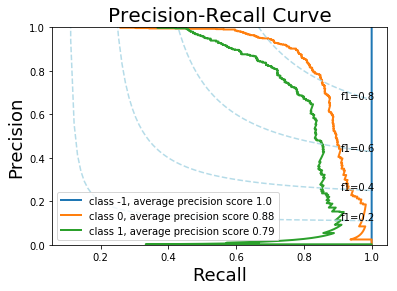

In [111]:
from sklearn import metrics
plot_precision_recall(BestLogRegGS,y_test_bin,X_test)

In [112]:
def plot_roc(model,y_bin,X):
    fpr = {}
    tpr = {}
    for i, cl in enumerate(model.classes_):
        fpr[cl], tpr[cl], _ = metrics.roc_curve(y_bin[:,i],model.predict_proba(X)[:,i])
    auc_scores = [round(metrics.roc_auc_score(y_bin[:,i],model.predict_proba(X)[:,i]),2) for i in range(len(model.classes_))]
    for i, key in enumerate(fpr.keys()):
        plt.plot(fpr[key],tpr[key],lw=2,label='class {}, ROC_AUC {}'.format(key,auc_scores[i]))
    plt.plot([0,1],[0,1],ls='--',lw=2)
    plt.ylim([0,1.05])
    plt.legend(loc='lower right')
    plt.title('ROC Curve',fontsize=20)
    plt.xlabel('FPR',fontsize=18)
    plt.ylabel('TPR',fontsize=18)
    
    plt.show()

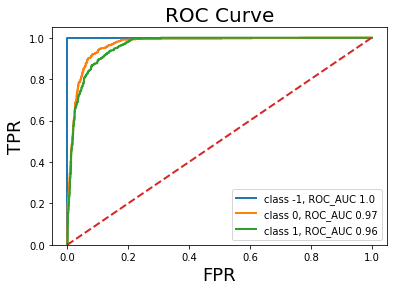

In [113]:
plot_roc(BestLogRegGS,y_test_bin,X_test)